# Document Research Assistant for Blog Creation

[![ Click here to deploy.](https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdeploynavy.svg)](https://console.brev.dev/launchable/deploy?launchableID=env-2qRrBuBdUGzzauhql87XCd7U1wR)

In this notebook, you will use NVIDIA NIM Microservices for the LLM, llama-3.3-70b, to generate a report on a given topic. You will also use a NIM for an NVIDIA text embedding model, nv-embedqa-e5-v5. Given a set of documents, LlamaIndex will create an Index which it can run queries against. 

You can get started by leveraging NVIDIA API Catalog and call a hosted model's NIM API Endpoint. Once you familiarize yourself with this blueprint, you may want to self-host models with NIM Microservices.

The Blueprint provides a workflow architecture for automating and orchestrating the creation of well-researched, high-quality content. 

The user provides a set of tools (e.g., a query engine with data about San Francisco's budget) and a content request (e.g., a question for a blog post). The Agent then:
1. Generates an Outline: Deploys an agent to structure the blog post into an actionable outline.
2. Plans Research Questions: Another agent generates a list of questions necessary to address the outline effectively.
3. Parallel Research: Breaks the questions into discrete units that can be answered concurrently, using available tools for data collection.
4. Drafts the Content: A writer agent synthesizes the gathered answers into a cohesive blog post.
5. Performs Quality Assurance: A critic agent reviews the content for accuracy, coherence, and completeness, determining if revisions are necessary.
6. Iterative Refinement: If improvements are needed, the workflow repeats by generating additional questions and gathering more information until the desired quality is reached.

This workflow combines modularity, automation, and iterative refinement to ensure the output meets the highest standards of quality. 

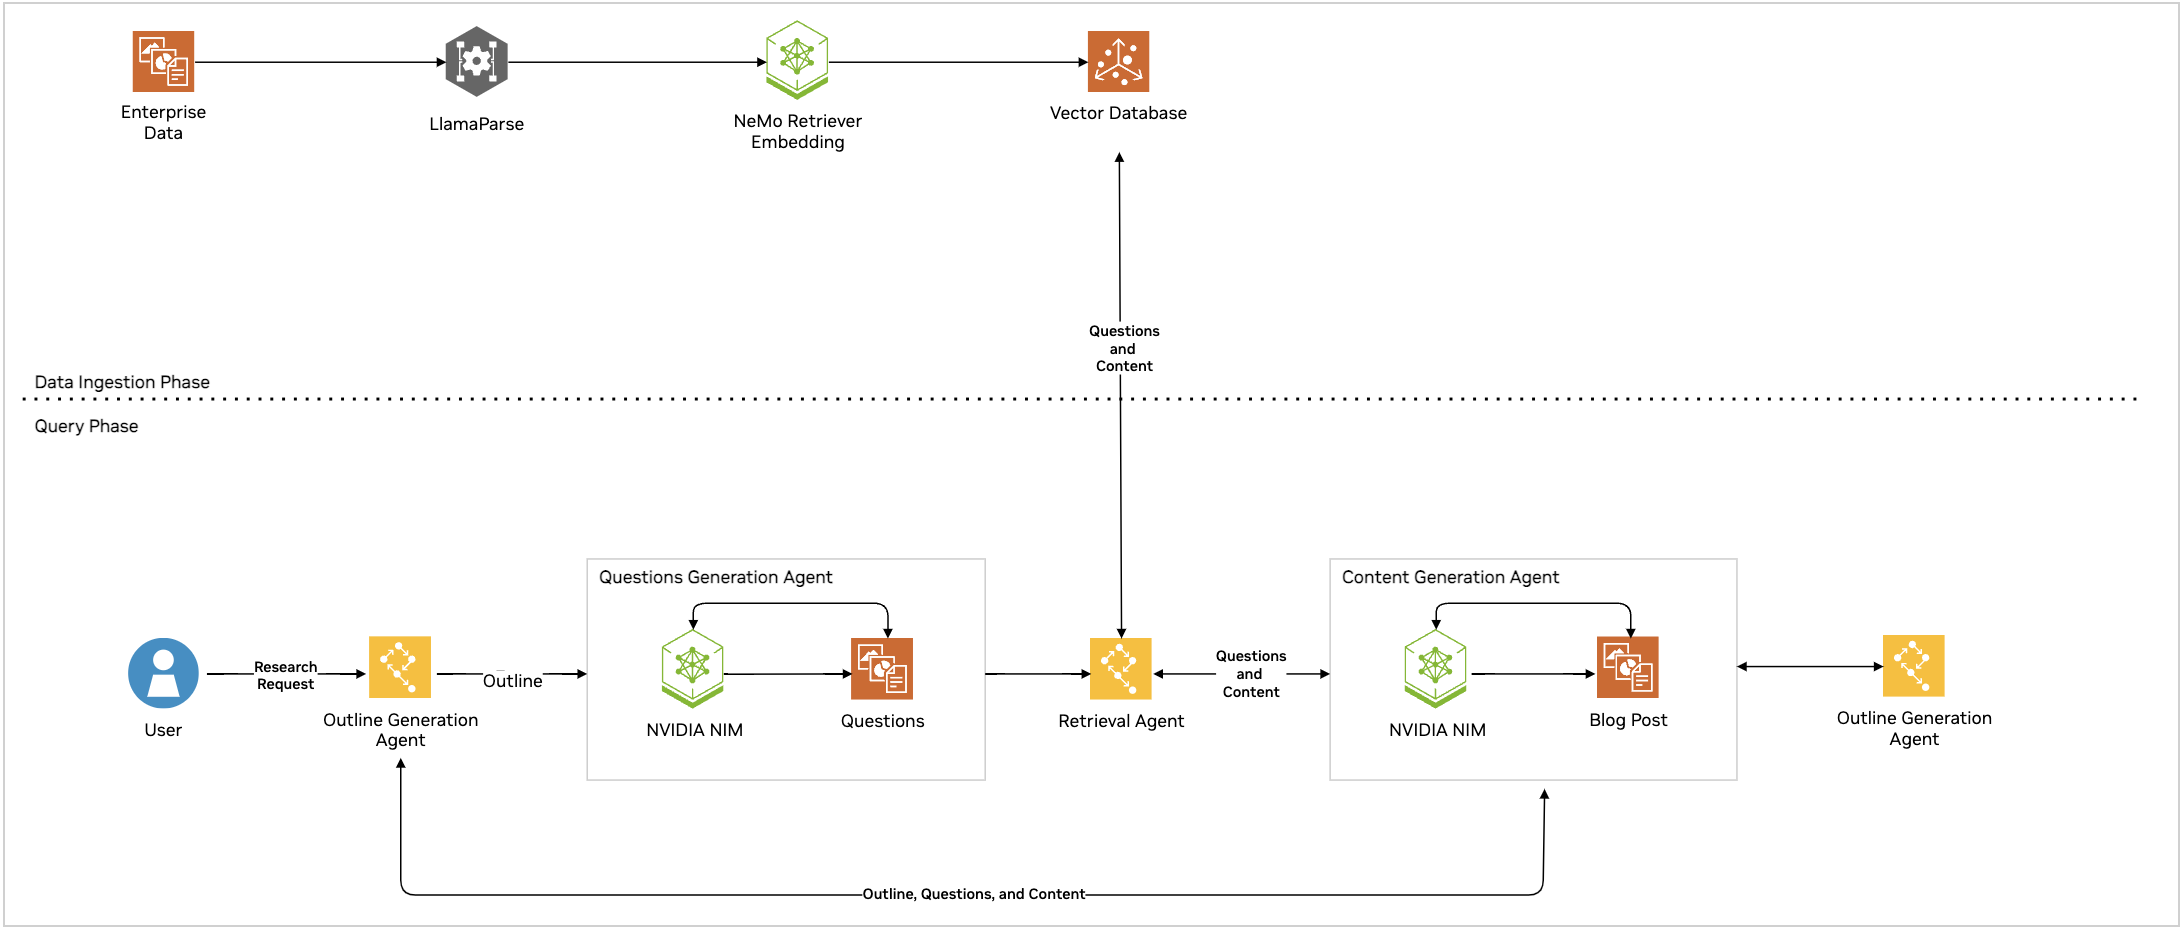

# Content Overview
>[Prerequisites](#Prerequisites)  
>[Create New Index from Document](#Create-New-Index-from-Document)  
>[Create Engine Query Tool](#Create-Engine-Query-Tool)  
>[Build the Agent](#Build-the-Agent)  
>[Test the Agent](#Test-the-Agent)  
________________________

## Prerequisites

### Install Dependencies

In [ ]:
!pip install llama-index-core
!pip install llama-index-core
!pip install llama-index-llms-nvidia
!pip install llama-index-embeddings-nvidia
!pip install llama-index-utils-workflow
!pip install llama-parse

If your environment does not have `wget` , make sure to install that as well.

### Download data

The data for this notebook is the City of San Francisco's Proposed Budget.

In [ ]:
!wget "https://www.dropbox.com/scl/fi/vip161t63s56vd94neqlt/2023-CSF_Proposed_Budget_Book_June_2023_Master_Web.pdf?rlkey=hemoce3w1jsuf6s2bz87g549i&dl=0" -O "san_francisco_budget_2023.pdf"

In [ ]:
# llama-parse is async-first, running the async code in a notebook requires the use of nest_asyncio
import nest_asyncio

nest_asyncio.apply()

## API Keys
Prior to getting started, you will need to create API Keys for the NVIDIA API Catalog if you're not self-hosting a model and LlamaIndex to use LlamaCloud. 

- NVIDIA API Catalog
  1. Navigate to **[NVIDIA API Catalog](https://build.nvidia.com/explore/discover)**.
  2. Select any model, such as llama-3.3-70b-instruct.
  3. On the right panel above the sample code snippet, click on "Get API Key". This will prompt you to log in if you have not already.
- LlamaIndex
  1. Go to **[LlamaIndex login page](https://cloud.llamaindex.ai/login)**. You will need to create an account if you have not already.
  2. On the left panel, navigate to "API Key".
  3. Click on the "Generate New Key" on the top of the page.

### Export API Keys

Save these API Keys as environment variables.

First, set the NVIDIA API Key as the environment variable. 

In [ ]:
import getpass
import os

if not os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    nvapi_key = getpass.getpass("Enter your NVIDIA API key: ")
    assert nvapi_key.startswith(
        "nvapi-"
    ), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key

Next, set the LlamaIndex API Key for LlamaCloud.

In [ ]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("LLAMA_CLOUD_API_KEY")

### Working with the NVIDIA API Catalog
Let's test the API endpoint.

We'll use both an LLM and embedding model in this notebook so we'll import both the packages now. 

In [ ]:
from llama_index.embeddings.nvidia import NVIDIAEmbedding
from llama_index.llms.nvidia import NVIDIA
from llama_index.core.llms import ChatMessage, MessageRole

llm = NVIDIA(model="meta/llama-3.3-70b-instruct")

messages = [
    ChatMessage(
        role=MessageRole.SYSTEM,
        content=("You are a helpful assistant that answers in one sentence."),
    ),
    ChatMessage(
        role=MessageRole.USER,
        content=("What are the most popular house pets in North America?"),
    ),
]

response = llm.chat(messages)

print(response)

assistant: The most popular house pets in North America are dogs, cats, fish, birds, and small mammals such as hamsters, guinea pigs, and rabbits, with dogs and cats being the clear favorites among pet owners.


### Optional: Locally Run NVIDIA NIM Microservices

Once you familiarize yourself with this blueprint, you may want to self-host models with NVIDIA NIM Microservices using NVIDIA AI Enterprise software license. This gives you the ability to run models anywhere, giving you ownership of your customizations and full control of your intellectual property (IP) and AI applications.

[Learn more about NIM Microservices](https://developer.nvidia.com/blog/nvidia-nim-offers-optimized-inference-microservices-for-deploying-ai-models-at-scale/)

<div class="alert alert-block alert-success">
<b>NOTE:</b> Run the following cell only if you're using a local NIM Microservice instead of the API Catalog Endpoint.
</div>

In [ ]:
from llama_index.llms.nvidia import NVIDIA
from llama_index.core import Settings

# connect to an LLM NIM running at localhost:8000, specifying a model
Settings.llm = NVIDIA(
    base_url="http://localhost:8000/v1", model="meta/llama-3.3-70b-instruct"
)

### Set LLM and Embedding Model

In this notebook, you will use the newest llama model, llama-3.3-70b-instruct, as the LLM.
You will also use NVIDIA's embedding model, nv-embedqa-e5-v5.

In [ ]:
from llama_index.core import Settings

Settings.llm = NVIDIA(model="meta/llama-3.3-70b-instruct")
Settings.embed_model = NVIDIAEmbedding(
    model="nvidia/nv-embedqa-e5-v5", truncate="END"
)

## Create New Index from Document

In [ ]:
from llama_index.core import (
    VectorStoreIndex,
    StorageContext,
    load_index_from_storage,
)
from llama_parse import LlamaParse

DATA_DIR = "./data"
PERSIST_DIR = "./storage"

if os.path.exists(PERSIST_DIR):
    print("Loading existing index...")
    storage_context = StorageContext.from_defaults(persist_dir=PERSIST_DIR)
    index = load_index_from_storage(storage_context)
else:
    print("Creating new index...")

    file_path = "./san_francisco_budget_2023.pdf"

    documents = LlamaParse(
        result_type="markdown",
        auto_mode=True,
        auto_mode_trigger_on_image_in_page=True,
        auto_mode_trigger_on_table_in_page=True,
        # auto_mode_trigger_on_text_in_page="<text_on_page>"
        # auto_mode_trigger_on_regexp_in_page="<regexp_on_page>"
    ).load_data(file_path)

    index = VectorStoreIndex.from_documents(documents)
    index.storage_context.persist(persist_dir=PERSIST_DIR)

### Run a Query Against the Index
Create a Query engine from the Index. A Query Engine is a generic interface that allows you to ask question over your data.
Here, the parameter `similarity_top_k` is set to 10. If you are using your own documents, you can play around with this parameter.

In [ ]:
query_engine = index.as_query_engine(similarity_top_k=10)
response = query_engine.query(
    "What was San Francisco's budget for Police in 2023?"
)
print(response)

The proposed Fiscal Year 2023-24 budget for the Police Department is $776.8 million.


## Create Engine Query Tool
Next, create a Query Engine Tool. This takes the Query Engine defined earlier and wraps it as a tool the Agent can use. 

In [ ]:
from llama_index.core.tools import QueryEngineTool

budget_tool = QueryEngineTool.from_defaults(
    query_engine,
    name="san_francisco_budget_2023",
    description="A RAG engine with extremely detailed information about the 2023 San Francisco budget.",
)

## Build the Agent

The workflow is:
* you give it a set of tools (in this case it's  a query engine with data about SF's budget)
* you give it a question to write a blog post about
* one agent generates an outline of what the blog post should look like
* the next generates a list of questions that would be necessary to gather data to fulfill that outline
* the questions are split up and answered concurrently
* a writer collects the questions and answers and writes a blog post
* a critic reviews the blog post and determines if it needs more work
  * if it's fine, the workflow stops
  * if it needs more work, it generates additional questions
  * those questions are answered and the process repeats

In [ ]:
from typing import List
from llama_index.core.workflow import (
    step,
    Event,
    Context,
    StartEvent,
    StopEvent,
    Workflow,
)
from llama_index.core.agent import FunctionCallingAgent


class OutlineEvent(Event):
    outline: str


class QuestionEvent(Event):
    question: str


class AnswerEvent(Event):
    question: str
    answer: str


class ReviewEvent(Event):
    report: str


class ProgressEvent(Event):
    progress: str


class DocumentResearchAgent(Workflow):
    # get the initial request and create an outline of the blog post knowing nothing about the topic
    @step()
    async def formulate_plan(
        self, ctx: Context, ev: StartEvent
    ) -> OutlineEvent:
        query = ev.query
        await ctx.set("original_query", query)
        await ctx.set("tools", ev.tools)

        prompt = f"""You are an expert at writing blog posts. You have been given a topic to write
        a blog post about. Plan an outline for the blog post; it should be detailed and specific.
        Another agent will formulate questions to find the facts necessary to fulfill the outline.
        The topic is: {query}"""

        response = await Settings.llm.acomplete(prompt)

        ctx.write_event_to_stream(
            ProgressEvent(progress="Outline:\n" + str(response))
        )

        return OutlineEvent(outline=str(response))

    # formulate some questions based on the outline
    @step()
    async def formulate_questions(
        self, ctx: Context, ev: OutlineEvent
    ) -> QuestionEvent:
        outline = ev.outline
        await ctx.set("outline", outline)

        prompt = f"""You are an expert at formulating research questions. You have been given an outline
        for a blog post. Formulate a series of simple questions that will get you the facts necessary
        to fulfill the outline. You cannot assume any existing knowledge; you must ask at least one
        question for every bullet point in the outline. Avoid complex or multi-part questions; break
        them down into a series of simple questions. Your output should be a list of questions, each
        on a new line. Do not include headers or categories or any preamble or explanation; just a
        list of questions. For speed of response, limit yourself to 8 questions. The outline is: {outline}"""

        response = await Settings.llm.acomplete(prompt)

        questions = str(response).split("\n")
        questions = [x for x in questions if x]

        ctx.write_event_to_stream(
            ProgressEvent(
                progress="Formulated questions:\n" + "\n".join(questions)
            )
        )

        await ctx.set("num_questions", len(questions))

        ctx.write_event_to_stream(
            ProgressEvent(progress="Questions:\n" + "\n".join(questions))
        )

        for question in questions:
            ctx.send_event(QuestionEvent(question=question))

    # answer each question in turn
    @step()
    async def answer_question(
        self, ctx: Context, ev: QuestionEvent
    ) -> AnswerEvent:
        question = ev.question
        if (
            not question
            or question.isspace()
            or question == ""
            or question is None
        ):
            ctx.write_event_to_stream(
                ProgressEvent(progress=f"Skipping empty question.")
            )  # Log skipping empty question
            return None
        agent = FunctionCallingAgent.from_tools(
            await ctx.get("tools"),
            verbose=True,
        )
        response = await agent.aquery(question)

        ctx.write_event_to_stream(
            ProgressEvent(
                progress=f"To question '{question}' the agent answered: {response}"
            )
        )

        return AnswerEvent(question=question, answer=str(response))

    # given all the answers to all the questions and the outline, write the blog poost
    @step()
    async def write_report(self, ctx: Context, ev: AnswerEvent) -> ReviewEvent:
        # wait until we receive as many answers as there are questions
        num_questions = await ctx.get("num_questions")
        results = ctx.collect_events(ev, [AnswerEvent] * num_questions)
        if results is None:
            return None

        # maintain a list of all questions and answers no matter how many times this step is called
        try:
            previous_questions = await ctx.get("previous_questions")
        except:
            previous_questions = []
        previous_questions.extend(results)
        await ctx.set("previous_questions", previous_questions)

        prompt = f"""You are an expert at writing blog posts. You are given an outline of a blog post
        and a series of questions and answers that should provide all the data you need to write the
        blog post. Compose the blog post according to the outline, using only the data given in the
        answers. The outline is in <outline> and the questions and answers are in <questions> and
        <answers>.
        <outline>{await ctx.get('outline')}</outline>"""

        for result in previous_questions:
            prompt += f"<question>{result.question}</question>\n<answer>{result.answer}</answer>\n"

        ctx.write_event_to_stream(
            ProgressEvent(progress="Writing report with prompt:\n" + prompt)
        )

        report = await Settings.llm.acomplete(prompt)

        return ReviewEvent(report=str(report))

    # review the report. If it still needs work, formulate some more questions.
    @step
    async def review_report(
        self, ctx: Context, ev: ReviewEvent
    ) -> StopEvent | QuestionEvent:
        # we re-review a maximum of 3 times
        try:
            num_reviews = await ctx.get("num_reviews")
        except:
            num_reviews = 1
        num_reviews += 1
        await ctx.set("num_reviews", num_reviews)

        report = ev.report

        prompt = f"""You are an expert reviewer of blog posts. You are given an original query,
        and a blog post that was written to satisfy that query. Review the blog post and determine
        if it adequately answers the query and contains enough detail. If it doesn't, come up with
        a set of questions that will get you the facts necessary to expand the blog post. Another
        agent will answer those questions. Your response should just be a list of questions, one
        per line, without any preamble or explanation. For speed, generate a maximum of 4 questions.
        The original query is: '{await ctx.get('original_query')}'.
        The blog post is: <blogpost>{report}</blogpost>.
        If the blog post is fine, return just the string 'OKAY'."""

        response = await Settings.llm.acomplete(prompt)

        if response == "OKAY" or await ctx.get("num_reviews") >= 3:
            ctx.write_event_to_stream(
                ProgressEvent(progress="Blog post is fine")
            )
            return StopEvent(result=report)
        else:
            questions = str(response).split("\n")
            await ctx.set("num_questions", len(questions))
            ctx.write_event_to_stream(
                ProgressEvent(progress="Formulated some more questions")
            )
            for question in questions:
                ctx.send_event(QuestionEvent(question=question))

## Test the Agent

Run the Agent with a query and look at the generated blog post written to answer it

In [ ]:
agent = DocumentResearchAgent(timeout=600, verbose=True)
handler = agent.run(
    query="Tell me about the budget of the San Francisco Police Department in 2023",
    tools=[budget_tool],
)
async for ev in handler.stream_events():
    if isinstance(ev, ProgressEvent):
        print(ev.progress)
final_result = await handler
print("------- Blog post ----------\n", final_result)

Running step formulate_plan
Step formulate_plan produced event OutlineEvent
Outline:
Here is a detailed outline for the blog post on the budget of the San Francisco Police Department in 2023:

**I. Introduction**

* Brief overview of the San Francisco Police Department (SFPD) and its role in the city
* Importance of understanding the budget of the SFPD
* Thesis statement: The 2023 budget of the San Francisco Police Department is a critical component of the city's public safety strategy, and understanding its allocation and priorities is essential for ensuring effective policing and community safety.

**II. Overview of the 2023 Budget**

* Total budget allocation for the SFPD in 2023
* Comparison to previous years' budgets (e.g., 2022, 2021)
* Breakdown of the budget into major categories (e.g., personnel, operations, equipment, training)

**III. Personnel Costs**

* Salary and benefits for sworn officers and civilian staff
* Number of personnel and staffing levels
* Recruitment and ret

## Sample output rendered as markdown

We've taken the output of the agent and rendered it here:

**The 2023 Budget of the San Francisco Police Department: Understanding Allocation and Priorities**

The San Francisco Police Department (SFPD) plays a vital role in maintaining public safety and order in the city of San Francisco. As such, understanding the budget of the SFPD is crucial for ensuring effective policing and community safety. The 2023 budget of the SFPD is a critical component of the city's public safety strategy, and this blog post aims to provide an overview of the budget allocation and priorities.

**Overview of the 2023 Budget**

The total budget allocation for the SFPD in 2023 is $776.8 million. Compared to the 2022 budget, the 2023 budget has increased, although the exact percentage increase is not specified. The major categories of expenditure in the 2023 budget include citywide expenditures such as voter-mandated General Fund support for transit, libraries, and other baselines, as well as expenditures related to Human Welfare & Neighborhood Development.

**Personnel Costs**

The personnel costs, including salary and benefits, for sworn officers in the 2023 SFPD budget are not explicitly stated. However, the Sheriff's Office budget for FY 2023-24 is $291.7 million, which includes funding for personnel costs such as salaries and benefits. The proposed budget for FY 2024-25 is $293.7 million, which is 0.7 percent higher than the FY 2023-24 proposed budget, mainly due to increases in interdepartmental services and salaries and benefits.

**Operational Expenses**

The operational expenses, including fuel and vehicle maintenance, have a significant budget allocation. Although the exact figure for the 2023 SFPD budget is not provided, the operational expenses for 2024-2025 have a budget of $1,088,786,650. This category likely encompasses a broad range of expenditures related to the upkeep and operation of vehicles and other equipment.

**Community Policing and Outreach Initiatives**

The 2023 budget allocates significant funding to support community policing and outreach initiatives. Specifically, the budget allocates $2.2 million in FY 2023-24 and $3.0 million in FY 2024-25 to support the expansion of Community Police Service Aides (PSAs) programs, $2.8 million in FY 2023-24 and $2.9 million in FY 2024-25 to support the expansion of ambassador programs, and $26.5 million in FY 2023-24 and $16.0 million in FY 2024-25 to support the expansion of Community Safety Ambassadors. These investments aim to enhance community outreach and engagement, and provide additional support services to address community needs.

**Technology and Equipment Upgrades**

The City of San Francisco is planning or undertaking various technology and equipment upgrades, including replacing critical systems, developing new platforms to enhance city services and operations, expanding and optimizing cloud services, improving digital accessibility and inclusion, and developing new applications to enhance the speed, security, performance, and reliability of City services. Although the exact budget allocation for these upgrades is not specified, these initiatives aim to support the city's goals and improve policing and public safety.

**Challenges and Controversies**

The SFPD faces significant budget challenges, including recruitment and retention issues, chronic understaffing, and the need to implement reforms and achieve substantial compliance with state laws. The Department must balance competing demands and priorities to ensure effective and responsible use of its budget. Controversies surrounding the SFPD budget may include the use of overtime funding, the implementation of new technologies and systems, and the allocation of resources for community programs and initiatives.

**Conclusion**

In conclusion, the 2023 budget of the San Francisco Police Department is a critical component of the city's public safety strategy. Understanding the budget allocation and priorities is essential for ensuring effective policing and community safety. The budget allocates significant funding to support community policing and outreach initiatives, technology and equipment upgrades, and personnel costs. However, the SFPD also faces significant budget challenges and controversies, which must be addressed to ensure the effective and responsible use of its budget. As the city continues to evolve and grow, it is essential to prioritize public safety and ensure that the SFPD has the necessary resources to maintain order and protect the community.

## Agentic strategies produce better results

As you can see in the output, the agent attempts to fulfill the request with an initial set of questions and answers, decides it needs more input, and asks more questions before settling on the final result. This ability to self-reflect and improve is part of why agentic strategies are such a powerful way to improve the quality of generative AI output.